Daily weather summaries obtained from: https://www.ncdc.noaa.gov/cdo-web/search

In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate

In [2]:
def agg_rides_daily():
    # read cleaned data from prior notebook
    r_df = pd.read_pickle('data/rides_with_dist.pkl')

    # Aggregate rides table to daily counts
    r_df = (r_df[['start_time']].groupby(r_df['start_time'].dt.date)
                                .count()
                                .rename(columns={'start_time':'n_rides'}))

    r_df.index.names = ['date']
    r_df.index = pd.to_datetime(r_df.index)
    r_df.to_csv('data/daily_rides.csv')

# agg_rides_daily()

In [3]:
def load_rides():
    r_df = pd.read_csv('data/daily_rides.csv', index_col=0)
    r_df.index = pd.to_datetime(r_df.index)

    # Ensure we fill 0's for days that had no rides
    all_dates = pd.date_range(r_df.index.min(), r_df.index.max(), name='date')
    all_dates = pd.DataFrame({'n_rides':0}, index=all_dates)

    r_df = r_df.append(all_dates.loc[~all_dates.index.isin(r_df.index)])
    r_df = r_df.sort_values('date')
    
    return r_df

def load_weather():
    # Aggregate weather to daily averages
    weather_csvs = [
        'weather_2013.csv',
        'weather_2014.csv',
        'weather_2015_2016.csv',
        'weather_2017_2018.csv',
    ]

    weather_dfs = []
    for csv in weather_csvs:
        weather_dfs.append(pd.read_csv(f'data/{csv}'))

    w_daily = pd.concat(weather_dfs, sort=True)

    # Collapse across weather stations by taking the mean
    w_daily = w_daily.groupby('DATE').mean()
    w_daily.index.names = ['date']
    w_daily.index = pd.to_datetime(w_daily.index)
    
    return w_daily

def base_feature_engineer(df):
    df = df.copy()
    df['n_rides_yesterday'] = df.n_rides.shift(1)
    df = df.drop(index=df.index[0])
    
    return df

In [4]:
r_df = load_rides()
w_df = load_weather()

C:\Users\City_Year\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (7,9,11,13,21,29,31,33,39,41,45,55,57,61,63,65,67,69,71,73,75) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\City_Year\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (7,13,21,27,29,31,33,39,41,45,55,57,59,61) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\City_Year\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (7,9,11,13,21,27,29,31,33,39,41,45,51,55,57,59,61) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\City_Year\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (7,9,11,13,21,29,31,33,39,41,43,45,47,49,51,53,55,57,59) have mixed types. Specify dtyp

In [5]:
w_data_dict = {
    'PRCP':'Precipitation',
#     'SNWD':'Snow depth',
    'AWND':'Average wind speed',
    'WSF2':'Fastest 2-minute wind speed',
    'WSF5':'Fastest 5-second wind speed',
#     'WDF2':'Direction of fastest 2-minute wind',
#     'WDF5':'Direction of fastest 5-second wind',
#     'WDMV':'Total wind movement',
#     'PGTM':'Peak gust time',
    'TMIN':'Minimum temperature',
    'TMAX':'Maximum temperature',
    'TAVG':'Average Temperature',
#     'DAPR':'Number of days included in the multiday precipitation total (MDPR)',
    'SNOW':'Snowfall',
#     'TOBS':'Temperature at the time of observation',
#     'WESD':'Water equivalent of snow on the ground',
#     'WESF':'Water equivalent of snowfall',
#     'MDPR':'Multiday precipitation total (use with DAPR and DWPR, if available)',
#     'WT01':'Fog, ice fog, or freezing fog (may include heavy fog)',
#     'WT02':'Heavy fog or heaving freezing fog (not always distinguished from fog)',
#     'WT03':'Thunder',
#     'WT04':'Ice pellets, sleet, snow pellets, or small hail',
#     'WT05':'Hail (may include small hail)',
#     'WT06':'Glaze or rime',
#     'WT08':'Smoke or haze',
#     'WT09':'Blowing or drifting snow',
#     'WT10':'Tornado, waterspout, or funnel cloud',
#     'WT11':'High or damaging winds',
}

In [6]:
df = r_df.merge(w_df[w_data_dict.keys()], left_index=True, 
                right_index=True, how='left')

df = base_feature_engineer(df)

df.isna().sum()

n_rides              0
PRCP                 0
AWND                 0
WSF2                 0
WSF5                 0
TMIN                 0
TMAX                 0
TAVG                 0
SNOW                 0
n_rides_yesterday    0
dtype: int64

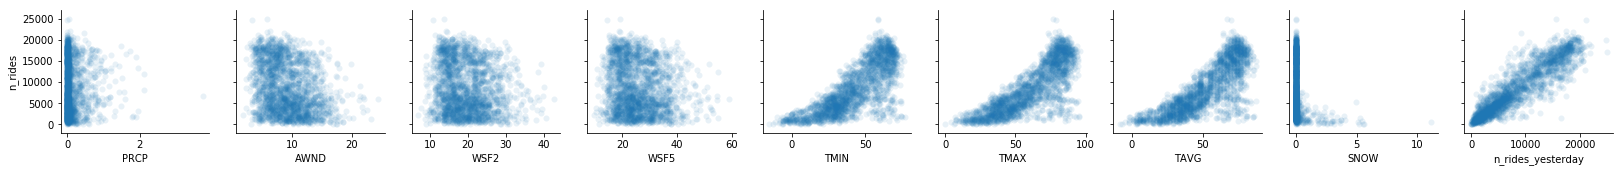

In [7]:
sns.pairplot(data=df, y_vars='n_rides', x_vars=df.columns.drop('n_rides'),
             plot_kws={'alpha': 0.1, 'linewidth':0});

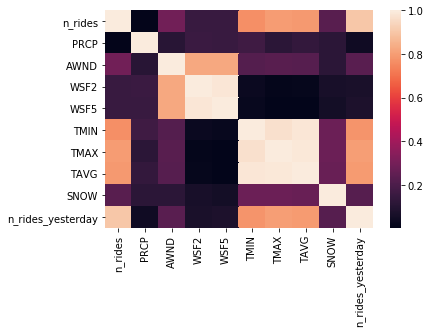

In [8]:
sns.heatmap(df.corr().abs());

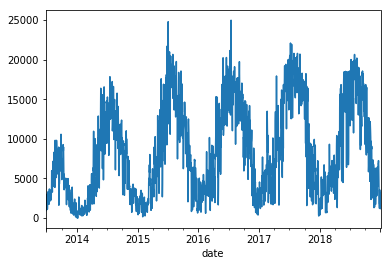

In [9]:
df.n_rides.plot();

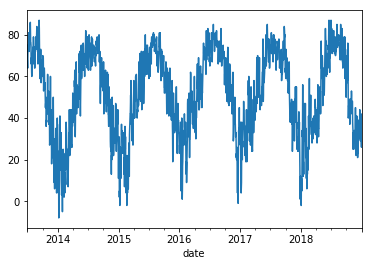

In [10]:
df.TAVG.plot();

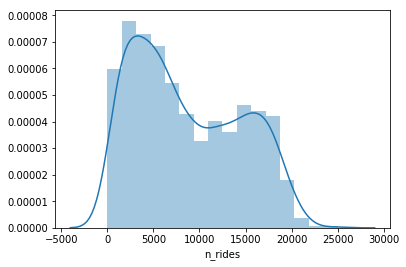

In [15]:
sns.distplot(df.n_rides);

In [16]:
def my_train_test_split(df):
    df = df.copy()
    # separate the final 100 days into test set
    train = df[:-100]
    test  = df[-100:]
    
    X_train = train.drop(columns='n_rides')
    y_train = train['n_rides']

    X_test = test.drop(columns='n_rides')
    y_test = test['n_rides']
    
    return X_train, y_train, X_test, y_test

In [17]:
X_train, y_train, X_test, y_test = my_train_test_split(df)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1913, 9), (1913,), (100, 9), (100,))

### Naive Models - Performance to Beat

In [18]:
y_pred = [y_train.mean()] * len(y_train)
mea = mean_absolute_error(y_train, y_pred)
print('daily average model MEA: ', mea)

y_pred = X_train['n_rides_yesterday']
mea = mean_absolute_error(y_train, y_pred)
print('same as yest. model MEA: ', mea)

daily average model MEA:  5131.410319084024
same as yest. model MEA:  1777.6941975953998


### First Viable Model

In [42]:
scores = cross_validate(LinearRegression(), X_train, y_train, 
                        scoring='neg_mean_absolute_error', 
                        n_jobs=-1, cv=10, return_estimator=True, 
                        return_train_score=True)

In [48]:
def cross_val_df(cv_scores):
    ls = []
    for i, est in enumerate(cv_scores['estimator']):
        x = dict(model_id = i,
                 test_score = cv_scores['test_score'][i],
                 intercept = est.intercept_)
        y = dict(zip(X_train.columns, est.coef_))
        z = {**x, **y}
        ls.append(z)
    df = pd.DataFrame(ls).set_index('model_id')
    
    return df

In [49]:
scores_df = cross_val_df(scores)
scores_df

,AWND,PRCP,SNOW,TAVG,TMAX,TMIN,WSF2,WSF5,intercept,n_rides_yesterday,test_score
model_id,,,,,,,,,,,
0,66.033200,277.601429,-13.634507,122.301461,85.969249,-104.530143,-344.353176,124.293094,23.538895,0.549641,-3036.615803
1,87.589249,1158.277530,-112.170985,108.669347,62.451548,-124.991471,-208.343336,35.465877,351.633714,0.751477,-1353.054019
2,87.832141,1240.869819,-151.766598,125.135493,51.507809,-130.095805,-214.577893,36.404397,450.961192,0.752188,-1225.914265
3,80.574366,1128.164467,-135.946097,80.032572,74.464862,-111.831542,-188.912293,24.984110,378.375643,0.761827,-1904.400933
4,83.734413,1101.881587,-91.143675,106.016443,60.810241,-120.839002,-219.995124,42.641585,427.195947,0.752031,-1393.817908
5,64.176815,1031.960655,-132.622655,98.375638,58.811778,-116.347336,-208.944220,48.677972,424.436374,0.767745,-1972.662742
6,73.842630,1157.540727,-171.698457,113.221919,56.358539,-125.484867,-164.042129,5.194322,433.532717,0.758221,-1584.385828
7,81.599180,1174.826659,-139.390548,85.392280,69.021229,-111.052686,-218.421414,42.851489,540.202211,0.748596,-2129.873457
8,71.455295,1414.064535,-118.381882,117.480313,54.483115,-128.782806,-192.272375,28.696495,371.361885,0.762897,-1683.391250


In [56]:
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,0.005008,0.001000,"LinearRegression(copy_X=True, fit_intercept=Tr...",-3036.615803,-1662.300384
1,0.004995,0.002012,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1353.054019,-1710.505090
2,0.005001,0.001005,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1225.914265,-1727.280296
3,0.004994,0.001001,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1904.400933,-1645.266385
4,0.005005,0.001997,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1393.817908,-1709.678041
5,0.004012,0.001986,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1972.662742,-1638.544377
6,0.003983,0.002002,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1584.385828,-1685.262604
7,0.004007,0.001995,"LinearRegression(copy_X=True, fit_intercept=Tr...",-2129.873457,-1631.749725
8,0.006001,0.002027,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1683.391250,-1673.923190
9,0.002968,0.002039,"LinearRegression(copy_X=True, fit_intercept=Tr...",-2037.763956,-1631.383305


### More feature engineering

In [85]:
def feature_engineer(df):
    df = df.copy()
    
    # dummify day of week
    df = df.join(pd.get_dummies(df.index.day_name())
                   .set_index(df.index))
    
    # boolean holiday
    cal = USFederalHolidayCalendar()
    hdays = cal.holidays(str(df.index.min().year), 
                         str(df.index.max().year + 1))
    df = df.join(pd.Series(1, index=hdays, name='holiday'))
    df['holiday'] = df['holiday'].fillna(0)
    
    # days program has operated
    df['operating_days'] = (df.index - df.index[0]).days
    
    def hours_of_daylight(date, axis=23.44, latitude=41.876):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    df['daylight_hrs'] = hours_of_daylight(df.index)
    
    # only for temps <= 50 F and winds > 3 mph
    # from https://www.weather.gov/media/epz/wxcalc/windChill.pdf
    df['windchill'] = (35.74 + (0.6215 * df['TAVG']) - (35.75 * df['AWND']) + 
                       (0.4275 * df['TAVG'] * df['AWND']))
    condition = (50 < df['TAVG']) | (3 < df['AWND'])
    df.loc[condition, 'windchill'] = df.loc[condition, 'TAVG']
    
    return df

In [86]:
df = r_df.merge(w_df[w_data_dict.keys()], left_index=True, 
                right_index=True, how='left')
df = base_feature_engineer(df)
df = feature_engineer(df)
X_train, y_train, X_test, y_test = my_train_test_split(df)

In [87]:
scores = cross_validate(LinearRegression(), X_train, y_train, 
                        scoring='neg_mean_absolute_error', 
                        n_jobs=-1, cv=10, return_estimator=True, 
                        return_train_score=True)

In [88]:
pd.options.display.max_columns = None
cross_val_df(scores).sort_values('test_score', ascending=False)

,AWND,Friday,Monday,PRCP,SNOW,Saturday,Sunday,TAVG,TMAX,TMIN,Thursday,Tuesday,WSF2,WSF5,Wednesday,daylight_hrs,holiday,intercept,n_rides_yesterday,operating_days,test_score,windchill
model_id,,,,,,,,,,,,,,,,,,,,,,
2,69.674861,262.327492,678.396893,896.441147,-54.321335,-216.221931,-838.183652,106.158122,74.512799,-129.773076,125.932980,142.904930,-272.123946,83.470385,-155.156712,143.538947,-1021.523859,-2083.054170,0.653751,1.209243,-1248.061361,2.844972
1,72.030453,225.287472,770.816150,761.859341,-70.877066,-236.729814,-859.996764,87.380656,78.364710,-113.233385,52.941554,146.060392,-253.612026,68.771919,-98.378990,122.046178,-1233.099596,-1785.165527,0.655716,1.179070,-1378.133462,3.745494
6,63.306367,203.456503,575.426122,799.625506,-92.442189,-89.701060,-857.831104,96.632121,75.160277,-122.142893,105.150668,124.237088,-215.338560,43.590909,-60.738216,146.060233,-975.401965,-1840.378942,0.659281,1.110552,-1426.203822,1.256656
4,64.917437,320.360890,575.670033,693.172794,-12.023527,-140.299176,-836.676497,39.202339,78.311763,-122.400263,106.680918,153.430342,-263.728130,76.933696,-179.166511,175.318202,-1003.917074,-2258.078051,0.638941,1.228011,-1463.373762,58.207355
8,61.386777,276.244939,466.310575,1001.364320,-17.547428,0.658908,-810.661119,105.208160,73.074285,-134.012421,68.711479,149.738251,-227.613468,53.307567,-151.003033,106.153564,-885.765071,-1610.154631,0.653378,1.306581,-1624.771440,8.265182
3,65.990644,256.304454,765.684179,758.789304,-32.995440,-308.794650,-785.304536,61.477222,94.720830,-108.399846,111.248624,101.061169,-227.130996,54.638430,-140.199239,110.881463,-1417.352473,-1690.944389,0.658189,1.145194,-1843.175055,5.728250
5,51.815926,215.796682,682.579999,702.980137,-64.730986,-255.765009,-858.889606,80.201901,77.997823,-114.132266,88.535555,178.899696,-245.708652,75.880605,-51.157316,117.247823,-1163.212407,-1592.481025,0.672086,1.079369,-1851.995804,5.658452
7,66.541196,255.098920,676.647625,873.298152,-73.975046,-313.975883,-780.799151,74.565585,81.712109,-113.444236,123.621691,96.008882,-268.984036,83.390348,-56.602084,132.643696,-1194.654475,-1603.340868,0.658996,1.084354,-1876.772394,7.193531
9,82.353306,306.716190,574.543071,739.711744,-55.787732,-99.692440,-774.432577,71.905003,86.198983,-109.994792,124.408224,74.920569,-210.501876,38.060566,-206.463038,183.768067,-929.911948,-2492.484905,0.658926,1.317524,-1942.671056,2.414911


In [89]:
X_train[['TAVG', 'AWND', 'windchill']]

,TAVG,AWND,windchill
date,,,
2013-06-28,75.0,10.066667,75.0
2013-06-29,68.0,11.406667,68.0
2013-06-30,68.0,13.123333,68.0
2013-07-01,68.0,11.783333,68.0
2013-07-02,65.0,10.510000,65.0
2013-07-03,64.0,4.326667,64.0
2013-07-04,69.0,5.666667,69.0
2013-07-05,74.0,4.923333,74.0
2013-07-06,75.0,5.293333,75.0


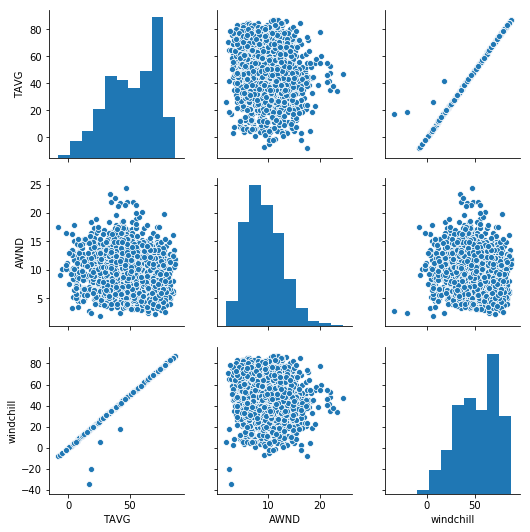

In [90]:
sns.pairplot(X_train[['TAVG', 'AWND', 'windchill']]);

In [91]:
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,0.087983,0.020005,"LinearRegression(copy_X=True, fit_intercept=Tr...",-2682.096246,-1550.924547
1,0.087983,0.020005,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1378.133462,-1591.108871
2,0.088994,0.020005,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1248.061361,-1612.448705
3,0.088994,0.020005,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1843.175055,-1532.974175
4,0.008001,0.008026,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1463.373762,-1598.070808
5,0.025004,0.002012,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1851.995804,-1530.012000
6,0.016000,0.002012,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1426.203822,-1588.645451
7,0.012006,0.001995,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1876.772394,-1530.573572
8,0.011009,0.003999,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1624.771440,-1574.007104
9,0.014009,0.003997,"LinearRegression(copy_X=True, fit_intercept=Tr...",-1942.671056,-1529.432185


In [92]:
scores['test_score'].mean()

-1733.7254402577848

### Grid Search on Polynomial terms

In [148]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

param_grid = {
    'polynomialfeatures__degree': [0, 1, 1.5, 2, 2.5, 3]
}

gs = GridSearchCV(PolynomialRegression(), param_grid=param_grid,
                  scoring='neg_mean_absolute_error', cv=10,
                  return_train_score=True, verbose=10, n_jobs=-1)

gs.fit(X_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-5314.601049535154, total=   0.0s
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-5206.582945961651, total=   0.0s
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-4272.550845559751, total=   0.0s
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-5480.239186748636, total=   0.0s
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-4820.909918455953, total=   0.0s
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-5274.873512474839, total=   0.0s
[CV] polynomialfeatures__degree=0 .......................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


[CV]  polynomialfeatures__degree=1, score=-1843.0282143355269, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-1430.8436860650631, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-1852.0648766800934, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-1426.3182102790624, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-1876.6032293887336, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-1624.0393584598678, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-1942.7035730253272, total=   0.0s
[CV] polynomialfeatures__degree=2 .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   39.2s finished
C:\Users\City_Year\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'polynomialfeatures__degree': [0, 1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=10)

In [152]:
pd.DataFrame(gridsearch.cv_results_).sort_values(by='rank_test_score')[['mean_train_score', 'mean_test_score']]

,mean_train_score,mean_test_score
2,-1246.738001,-1683.784347
1,-1563.945251,-1730.472755
0,-5121.745504,-5259.425269
3,-836.051316,-6333.475276


### Random Forest